# E-11] News_summary

# 목차
 1. 데이터 수집하기
 2. 데이터 전처리하기
 3. 모델(LSTM)설계하기
 4. 어텐션 메커니즘 사용하기
 5. 모델 훈련하기
 6. 인퍼런스 모델 구현하기(실제 모델)
 7. 모델 테스트하기
 8. 실제 결과와 요약문 비교하기
 9. Summa을 이용해서 추출적 요약해보기
 10. 회고

# 개념이해
* 텍스트 요약이란?
* seq2seq 이해하기
* Attention Mechanism
* LSTM 이해하기

## 텍스트 요약이란?
= 긴 문장에서 핵심 주제만 골라서 짧은 요약문으로 만드는 것

* 방법

1. 추출적 요약
원문에서 핵심적인 문장을 꺼내와서 핵심문장으로 구성된 요약문을 만드는 것
핵심문장이 원문에 그대로 있는것이 특징!

하지만 핵심문장간 연결이 매끄럽지 않을 수 있다.

2. 추상적 요약
원문에서 자연어를 생성해서 내용이 요약된 새로운 문장을 만드는 것!

In [146]:
from IPython.display import Image 

# LSTM
우리는 seq2seq를 구현할때 RNN(인코더,디코더)이 아닌 LSTM으로 인코더/디코더를 만들기 때문에 개념을 이해하고 넘어가자

RNN을 역전파할때 관련 정보와 다른 정보 사이의 거리가 멀 경우 그라디언트 손실이 발생한다.학습능력이 저하됨!(0)

이때 이를 해결하기 위해서 LSTM 사용한다. 

LSTM이란?
* gate(4개 레이어)가 존재한다. 이를 활용해서 정보를 더하거나 뺄 수 있다.
* RNN의 HIDDEN STATE에 CELL STATE를 추가한다.

밑에 그림을 참고하면 위에 이미지가 기존의 RNN구조, 밑에 이미지가 LSTM이다.

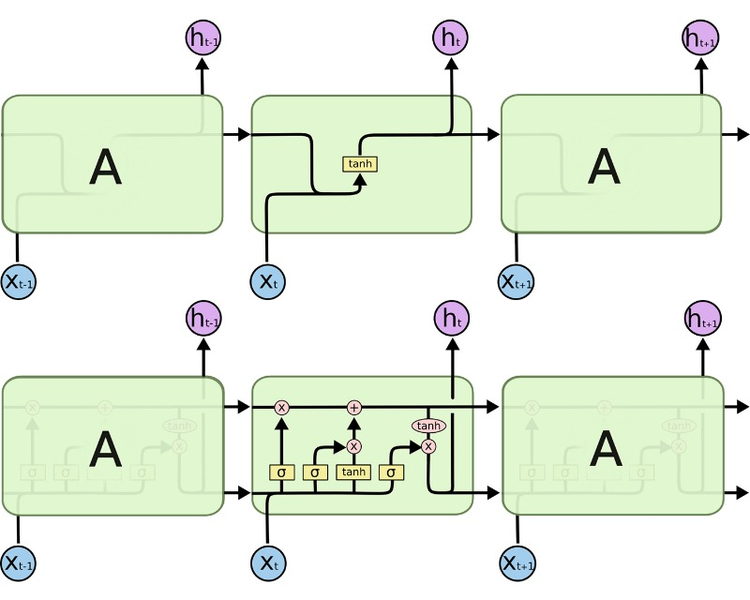

In [148]:
Image("/home/aiffel-dj54/Downloads/lstm.png")

셀 스테이트에 gates는 시그모이드 신경망 레이어와 곱하기 연산(pointwise)으로 구성됐다.
시그모이드는 0 or 1 값을 출력한다. 얼마나 정보를 전달해야하는지 확률로 나타낸다 
0이면 영향이 없고 1이면 영향을 많이 준다.

아래 그림은 기호를 더 직관적으로 이해하기 위해서 그린 그림이다.

file:///home/aiffel-dj54/Downloads/image.png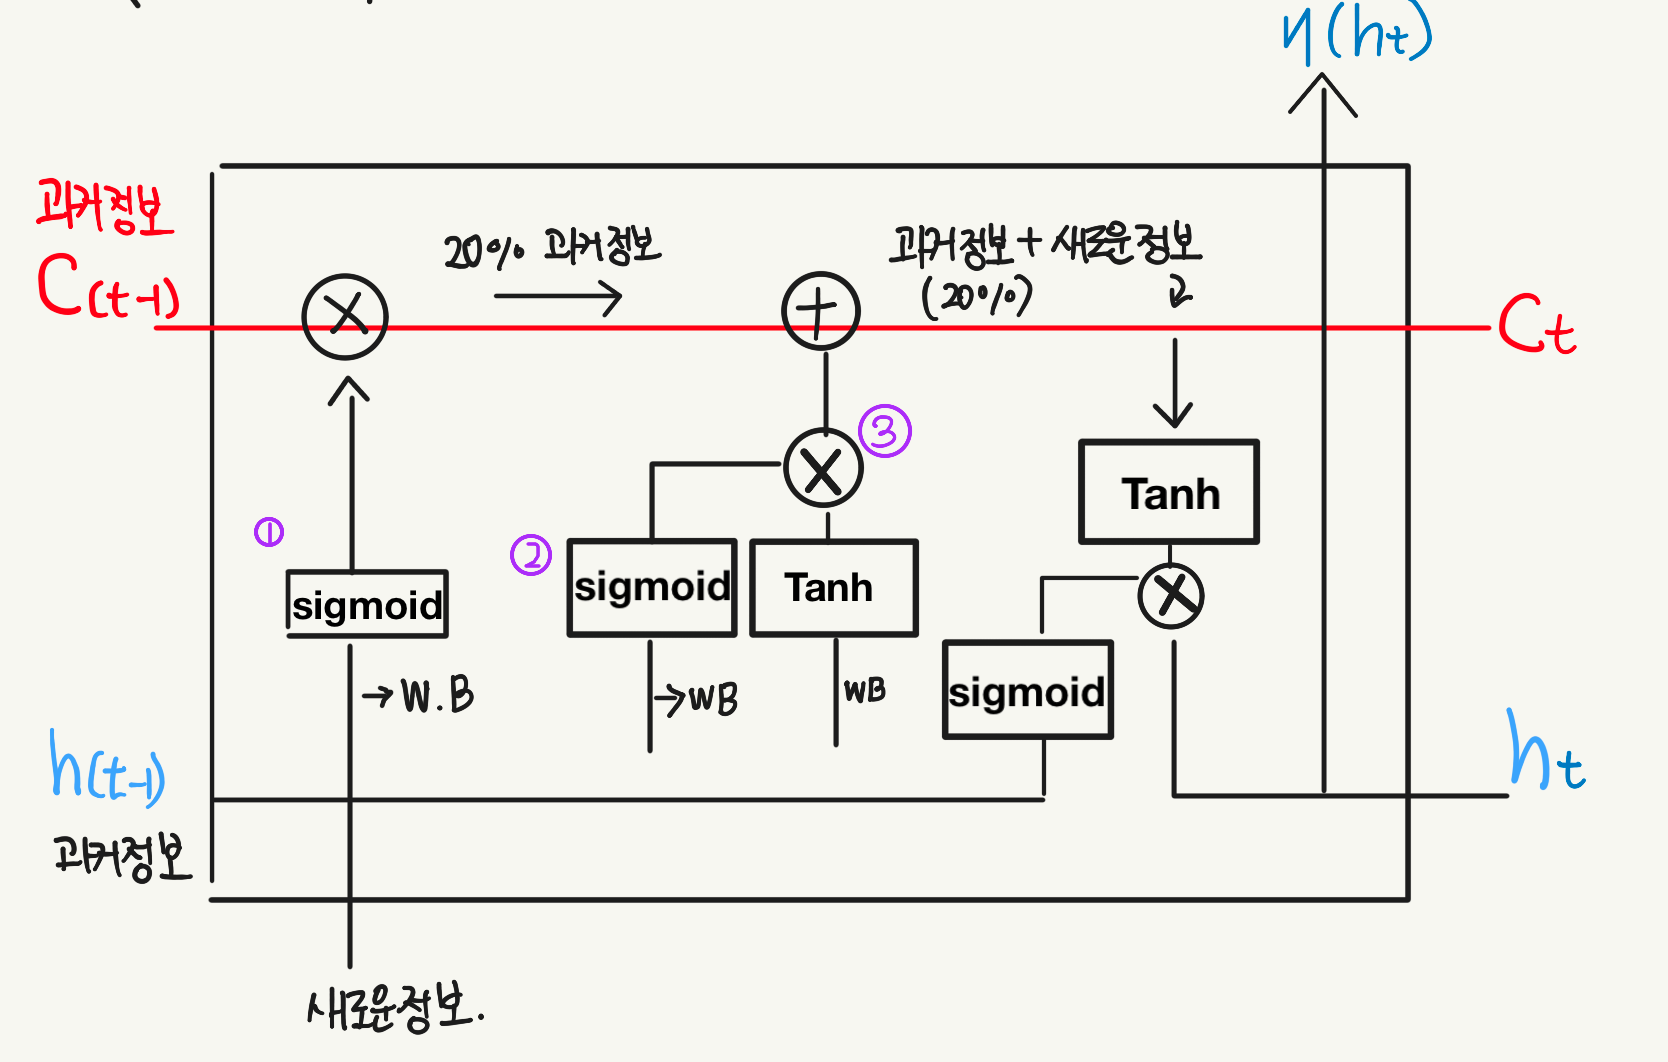

1. 셀스테이트에서 과거의 정보를 얼만큼 버릴지 유지할지 선택하는 과정
* 과거의 정보(ht-1)와 새로운 입력값(xt)가 입력되면 forget gate layer인 시그모이드가 몇퍼센트만 기억할지 정한다.
* 예를 들어 시그모이드가 20%가 나오면 과거의 정보를 20%만 기억한다는 것

2. 새로운 정보가 셀스테이트에 저장될지 결정하는 단계
* input gate layer(sigmoid)가 과거의 정보와 새로운 정보의 어떤 값을 업데이트 할지 결정한다.
* tanh layer 는 셀 스테이트에 더할 수 있는 새로운 값을 만든다.

3.과거의 정보를 새로운 정보에 더한다. 
* Ct = 과거의 정보* 퍼센트+ 과거의 정보* 새로운정보 

4.어떤 출력값을 출력할지 결정
* 시그모이드가 어떤 값을 출력할지 결정한다.
* 과거+새로운정보의 값이 tanh를 거쳐서 -1 or 1로 출력된다.
* 시그모이드에서 나온 값과 tanh를 겨쳐서 얻은 값이 곱해져서 출력된다.


# seq2seq
= 두개의 RNN구조를 사용해서 입력문장에서 출력문장을 만드는 자연어 생성 모델이다. 

file:///home/aiffel-dj54/Downloads/seq2seq.png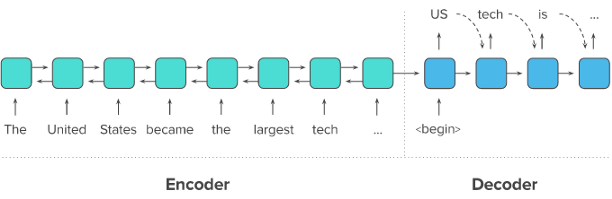

문장을 첫번째 RNN encoder에 입력하면 마지막 time step의 hidden state의 값을 컨텍스트 벡터로 사용한다. 

두번째 RNN decoder에 컨텍스트 벡터를 전달해서 한 단어씩 요약문장을 만든다.

하지만 이때 생기는 문제가 있다. 

컨텍스트 벡터는 고정된 크기의 vector만 담을 수 있다. 만약 문장이 길거나 컨텍스트 벡터의 크기가 입력된 문장에 비해 작으면 모든 정보를 담을 수 없다. 
즉, 요약이나 번역이 원래 의도를 표현하지 못한다. 

Attention Mechanism을 적용해서 정보 손실을 막을 수 있다. 

# Attention Mechanism

Attention Mechanism은 인코더의 모든 step의 hidden 값을 컨텍스트 벡터에 반영한다. 이때 동일한 비중으로 hidden 값이 전달되지 않는다. 

fully connected layer와 softmax를 사용해 전달될 hidden 값의 비중을 정한다. 

file:///home/aiffel-dj54/Downloads/image%20(1).png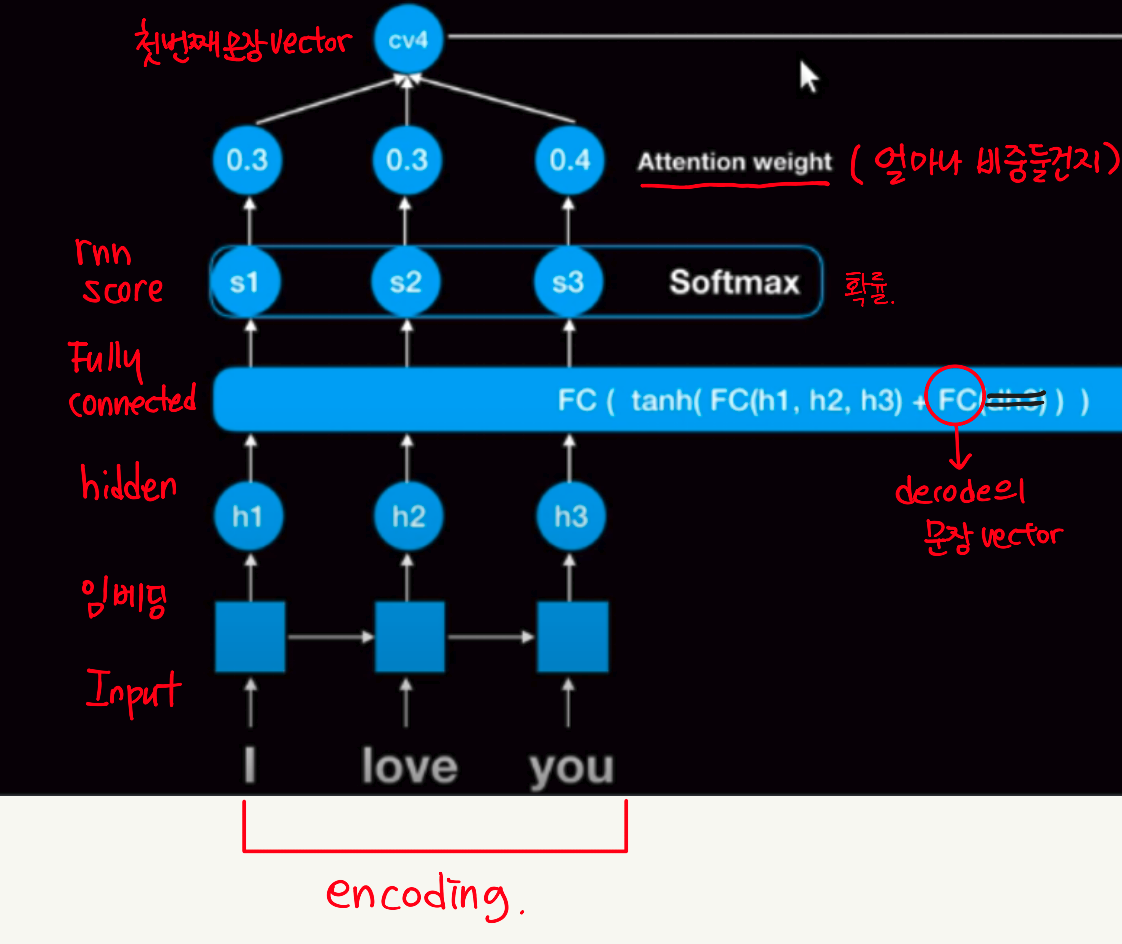

# 구조설명

기존의 seq2seq는 인코더의 마지막 time step의 hidden state 값을 decoder의 컨텍스트 벡터로 반영됐다. 

그래서 인코더의 모든 값이 동일한 비중이 아니였다. 

어텐션 메커니즘은 인코더의 모든 hidden state의 정보가 컨텍스트 벡터에 동일한 비중으로 반영된다.

decoder의 문장벡터가 다시 encoder로 들어오기 때문에 디코더의 스텝이 어디냐에 따라 컨텍스트 벡터의 값이 달라진다

* fullyconnected layer에 hiddenlayer(h1,h2,h3)의 값을 모두 구하고 decoder의 문장벡터를 추가하고 확률계산
* 소프트 맥스로 확률을 계산하고 각 단어가 얼만큼 비중을 가질지 계산한다.
* 이후 cv4( h1*0.3+h2*0.3+h3*0.4) 를 컨텍스트 벡터로 decoder에 넣는다.
* decoder가 첫번째 문장을 만든 후 그 결과값을 다시 encoder의 문장벡터에 넣고 확률을 계산한다. = 두번째 문장 컨텍스트 벡터 출력
* 이때 매순간 h1,h2,h3의 정보를 모두 사용한다.


# Step 1. 데이터 수집하기
이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [151]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj54/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [152]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
16917,"Paaji, galti ho gai: Harbhajan said to Wasim a...",Indian spinner Harbhajan Singh recalled that h...
32149,"Sonam, mom Sunita dance to London Thumakda at ...",A video shows actress Sonam Kapoor and her mot...
95079,SoftBank preparing for Snapdeal's sale to Flip...,Snapdeal's biggest investor SoftBank on Tuesda...
44418,"India, B'desh declare part of border crime fre...",India and Bangladesh have for the first time d...
85611,What is a light-year and how long is it?,Light-year is a unit to measure astronomical d...
56713,Teen actress' co-passenger says alleged molest...,A co-passenger of the teen Bollywood actress w...
5560,GSK and Pfizer to combine consumer health busi...,British pharmaceutical giant GlaxoSmithKline (...
58193,Govt may extend PAN-Aadhaar linkage deadline b...,The government will give three to six months t...
16015,Arbaaz to marry rumoured girlfriend Giorgia in...,Arbaaz Khan will marry his rumoured Italian gi...
91724,GoT actors paid Ã¢ÂÂ¹16 crore per episode: Re...,"According to reports, actors Emilia Clarke, Ki..."


In [4]:
# 전체 샘플 수 확인 
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


In [5]:
#필요한 칼럼만 남기기 TEXT 열의 내용을 요약한게 SUMMARY 
# 텍스트를 INPUT으로 받으면 요약을 예측하도록 모델 훈련
data = data.replace('headlines','Text')
data = data.replace('text','Summary')

#랜덤한 15개 샘플 출력
data.sample(15)

,headlines,text
794,Andhra teacher arrested for raping Class 2 gir...,A teacher has been arrested for allegedly rapi...
27405,Air India removes 'Taiwan' from website after ...,Air India has changed its reference to Taiwan ...
63595,"Shahid has shaant zen-like vibe, easy to work ...","Actor Ranveer Singh, while talking about his '..."
87125,Shahid tells Ishaan dating rumours can damage ...,"According to reports, actor Shahid Kapoor has ..."
81421,BJP takes responsibility to get Pak-returned G...,Union Minister Sushma Swaraj on Saturday said ...
89727,Punjab school teachers directed to dress 'dece...,Punjab's director for public instructions (sec...
78706,"Titanic stars Leonardo, Kate auction dinner da...",'Titanic' actors Leonardo DiCaprio and Kate Wi...
88057,India a victim of terrorism: Donald Trump,US President Donald Trump said in his speech i...
66969,"Samsung! You can do it, user on no headphone j...",Reacting to Google removing headphone jack fro...
24934,Mumbai to get 'skyscraper bridge' connecting W...,Authorities are planning to build a 4.5-km lon...


# Step 2. 데이터 전처리하기 
< 추상적 요약 선택 >
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

### 2-1) 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [6]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [7]:
# 중복데이터 제거 
data.drop_duplicates(subset = ['text'], inplace = True)
data.drop_duplicates(subset = ['headlines'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98262


In [8]:
# NULL값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
#NULL값 제거 
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98262


In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [11]:
#NLTK에서 정의한 불용어 : 이걸 기준으로 내 데이터의 불용어제거

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

# 2-2) 텍스트 정규화와 불용어 제거 함수 만들기
1. 정규화:
같은 의미인데 다른 단어로 취급되는 경우가 있음 그래서 미리 표현을 동일하게 만드는 작업
정규화 사전 출처:https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

        
* 영어문자 -> 소문자 = lower()
* HTML태그 제거 =  BeautifulSoup(sentence, "lxml").text
* 특수문자제거("",소유격,특수문자,추임새)
- 괄호안 문자열 제거 : (r'\([^)]*\)', '', sentence)
- 쌍따옴표 : ('"','', sentence)    
- 약어 정규화 : ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) 
- 소유격 제거 : (r"'s\b","",sentence)
- 영어 외 문자(숫자, 특수문자 등) 공백으로 변환 : ("[^a-zA-Z]", " ", sentence)
- m이 3개 이상이면 2개로 변경 : ('[m]{2,}', 'mm', sentence) Ex) ummmmmmm yeah -> umm yeah


2.불용어: 텍스트에 등장하지만 의미가 없는 단어
TEXT에서만 불용어를 제거하고 문장 길이가 짧은 요약은 불용어 제거 안함

In [12]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() 
    sentence = BeautifulSoup(sentence, "lxml").text 
    sentence = re.sub(r'\([^)]*\)', '', sentence) 
    sentence = re.sub('"','', sentence) 
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","",sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence) 
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
temp_text = 'Everything will be ok, the Future is <br /> bright.'
temp_headlines = 'hi HELLO or (bye) GOOD bye!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

everything ok future bright
hi hello or good bye


# 2-3) 전체 데이터 전처리 진행하기 
TEXT 전처리, SUMMARY 전처리(불용어제거하지 않음)

In [14]:
# text 전처리 

clean_text = []

# 전체 headlines 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [15]:
#SUMMARY 전처리 
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False)) # 불용어제거 안함(FALSE)

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [16]:
#텍스트 정제 과정에서 빈샘플 생길 수 있음 확인하기 
data['headlines'] = clean_headlines
data['text'] = clean_text

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True) # 빈샘플을 NULL값으로 바꾼다

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98262


# 학습준비
학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시 해줘야해요.

# 2-4)샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299444342675704


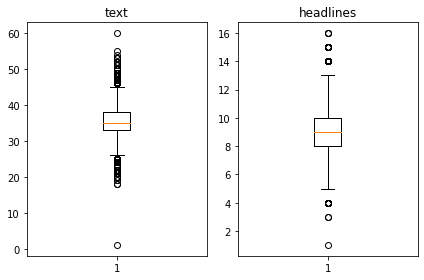

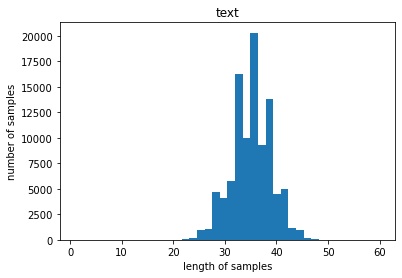

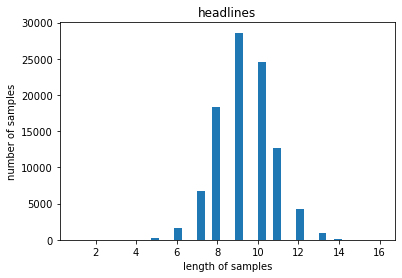

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')

plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
#적절한 최대 길이를 정하기
text_max_len = 41
headlines_max_len = 12

In [29]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [30]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 41 이하인 샘플의 비율: 0.9549368016120169
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880319960920804


In [31]:
# DATA에 있는 TEXT, SUMMARY 안에 문장의 길이를 최대길이보다 작거나 같으면 나눠서 데이터에 넣는다
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 92705


# 2-5) 시작 토큰과 종료 토큰 추가하기

In [32]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [33]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해줄게요.
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

# 2-6) 훈련데이터와 텍스트 데이터 분리

In [64]:
#  encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요. 임의로 숫자문장을 만듬
int_sequence = np.arange(encoder_input.shape[0])
np.random.shuffle(int_sequence)
print(int_sequence)

[66300 30605 66983 ... 15244 52816 19197]


In [65]:
#데이터 샘플 순서를 정의 
encoder_input = encoder_input[int_sequence]
decoder_input = decoder_input[int_sequence]
decoder_target = decoder_target[int_sequence]

In [66]:
# 섞인 데이터를 훈련과 테스트로 분리함 전체 데이터에 0.2 곱해서 테스트 크기 정한다
data_split = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',data_split)

테스트 데이터의 수 : 18541


In [86]:
encoder_input_train = encoder_input[:-data_split]
decoder_input_train = decoder_input[:-data_split]
decoder_target_train = decoder_target[:-data_split]

encoder_input_test = encoder_input[-data_split:]
decoder_input_test = decoder_input[-data_split:]
decoder_target_test = decoder_target[-data_split:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 74164
훈련 레이블의 개수 : 74164
테스트 데이터의 개수 : 18541
테스트 레이블의 개수 : 18541


# 2-7) 정수 인코딩(tokenizer)
기계가 텍스트를 숫자로 인식하도록 훈련과 데스트 데이터(문자)를 숫자로 바꿔야한다.= 각 단어에 숫자를 맵핑한다 = 단어집합이라고 부른다.

* 토크나이저를 사용해서 단어집합을 만든다.
* 빈도수가 낮은 단어는 제외한다
* 패딩하기

## train 데이터의 단어집합

In [87]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [88]:
threshold = 5
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67071
등장 빈도가 4번 이하인 희귀 단어의 수: 41667
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 25404
단어 집합에서 희귀 단어의 비율: 62.12371964038109
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7464652589555443


In [90]:
src_vocab = 15000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [91]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[525, 150, 323, 2937, 4140, 40, 2100, 7676, 636, 150, 3015, 129, 107, 1883, 3943, 2798, 1203, 473, 385, 2164, 1402, 4160, 129, 32, 1, 236, 150, 2061, 5, 1055, 355, 4, 487, 5163, 10517], [29, 1283, 4187, 11091, 1, 4974, 2, 965, 10793, 22, 270, 1, 332, 186, 3805, 10794, 14244, 1940, 680, 6, 8313, 8188, 93, 1, 189, 648, 529, 1472, 2203, 876, 833], [13246, 47, 2912, 2305, 3373, 74, 63, 3476, 2360, 216, 196, 2305, 1, 232, 627, 5739, 851, 111, 6388, 7242, 1326, 1348, 161, 3348, 326, 2955, 13730, 4, 196]]


In [92]:
#summary 정수인코딩
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [93]:
threshold = 3
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29299
등장 빈도가 2번 이하인 희귀 단어의 수: 14291
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15008
단어 집합에서 희귀 단어의 비율: 48.77640875115192
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.388526864680392


In [94]:
tar_vocab = 900
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 171, 133, 6, 301, 195, 165], [1, 48, 3, 21, 5, 59, 3, 796, 51, 646], [1, 184, 3], [1, 492, 137, 91, 3, 489, 11, 44, 473], [1, 618, 10, 3, 10]]
target
decoder  [[171, 133, 6, 301, 195, 165, 2], [48, 3, 21, 5, 59, 3, 796, 51, 646, 2], [184, 3, 2], [492, 137, 91, 3, 489, 11, 44, 473, 2], [618, 10, 3, 10, 2]]


## 길이가 0이 된 샘플제거 

In [95]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 60
삭제할 테스트 데이터의 개수 : 26
훈련 데이터의 개수 : 74104
훈련 레이블의 개수 : 74104
테스트 데이터의 개수 : 18515
테스트 레이블의 개수 : 18515


## 패딩하기

In [96]:
# 서로 다른 길이의 샘플을 같은 길이로 맞추는 작업

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post') #뒤에 숫자 0을 넣어서 최대길이로 맞춘다
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

# Step 3. 모델(LSTM)설계하기

In [97]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 64
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [98]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c]) #인코더의 hidden, cell state값 넣기 

In [99]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 41, 64)       960000      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 41, 256), (N 328704      embedding_6[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# Step 4. 어텐션 메커니즘 사용하기

In [100]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [101]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 41, 64)       960000      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 41, 256), (N 328704      embedding_6[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# Step 5. 모델 훈련하기

In [102]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2) 
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 40)

Epoch 1/40
290/290 [==============================] - 358s 1s/step - loss: 2.9796 - val_loss: 2.7387
Epoch 2/40
290/290 [==============================] - 351s 1s/step - loss: 2.6242 - val_loss: 2.4974
Epoch 3/40
290/290 [==============================] - 353s 1s/step - loss: 2.4324 - val_loss: 2.3564
Epoch 4/40
290/290 [==============================] - 358s 1s/step - loss: 2.3001 - val_loss: 2.2518
Epoch 5/40
290/290 [==============================] - 306s 1s/step - loss: 2.1961 - val_loss: 2.1595
Epoch 6/40
290/290 [==============================] - 289s 995ms/step - loss: 2.1128 - val_loss: 2.1021
Epoch 7/40
290/290 [==============================] - 287s 989ms/step - loss: 2.0469 - val_loss: 2.0631
Epoch 8/40
290/290 [==============================] - 287s 988ms/step - loss: 1.9907 - val_loss: 2.0299
Epoch 9/40
290/290 [==============================] - 287s 988ms/step - loss: 1.9431 - val_loss: 1.9975
Epoch 10/40
290/290 [==============================] - 287s 988ms/step - loss: 

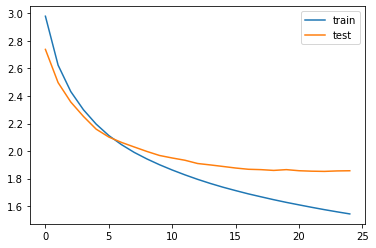

In [103]:
#훈련데이터의 손실과 검증데이터의 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 6.인퍼런스 모델 구현하기(실제 모델) 
테스트 단계에서는 정수 인덱스 행렬로 있던 텍스트 데이터를 실제 데이터로 복원해야한다. 

훈련단계에서는 샘플 데이터가 있어서 한개의 모델을 만들고 디코더 입력부분에 문장을 한번에 넣고 출력과 비교할 수 있었다.

하지만 실제론 입력되는 문장이 어떤것인지 알 수 없어서 문장길이를 알 수 없다.
문장길이 만큼 디코더가 반복해서 출력해야 하기 때문에 
인코더 모델과 디코더 모델을 분리해서 만들어야 한다.

In [104]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [105]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [106]:
# 어텐션 함수(출력층 설계)
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [107]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 7.  모델 테스트하기
테스트할때 숫자보단 텍스트로 보는것이 직관적이다. 
text 출력할때 패딩한 0 제외, summary 출력할때는 숫자0, 시작토큰, 종료토큰 제외 

In [108]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# Step 8. 실제 결과와 요약문 비교하기
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

In [109]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : katrina kaif said celebrity feel need opinion everything adding cannot opinion added well informed half things go world really want sit research would rather say anything 
실제 요약 : why cannot not have an as katrina 
예측 요약 :  am not on katrina


원문 : sonam kapoor saturday tweeted going twitter negative peace love recently told twitter user take public transport complained mumbai traffic men like women find difficult use public transport sonam replied user 
실제 요약 : sonam takes break from twitter says it is too 
예측 요약 :  twitter kapoor to sonam kapoor


원문 : india richest person mukesh ambani said world first billion dollar house mumbai road considered world expensive home storey building spread lakh square feet rises metres features three seater cinema nine six storey garage house cars 
실제 요약 : ambani the world first billion house 
예측 요약 :  world biggest billion in


원문 : goa politicians shared videos fields helping farmers agriculture challenge thrown sarpanch bhagat create awarenes

예측 요약 :  dead injured as hits in


원문 : spanish duo scored one goal help chelsea beat brighton premier league tuesday meanwhile manchester united rescued two goals one coming injury time drew burnley results second placed united one point chelsea 
실제 요약 : post win man score late to 
예측 요약 :  goal scores as man city


원문 : iran supreme leader ayatollah ali khamenei wednesday said us intention move embassy israel jerusalem recognising city israel capital sign failure khamenei accused us wanting start war region protect security israel 
실제 요약 : us on of iran 
예측 요약 :  us to us leader


원문 : mukhtar malik soldier home death teenage son killed suspected militants posing journalists jammu kashmir kulgam district monday attackers pretended shooting malik video house using mobile phone fired point blank range locals police said 
실제 요약 : terrorists kill who was home to son death 
예측 요약 :  kills son shot dead in


원문 : according reports actor hrithik roshan approached play shiva role film adapta

# Step 9. Summa을 이용해서 추출적 요약해보기

현재 seq2seq로 추상적 요약을 진행했다. 

#### summa
패키지 summa에는 추출적 요약 모듈 summarize제공한다.

내부에서 자동으로 문장토큰화 실행, 원문을 바로 입력해도 된다!

* 인자

text (str) : 요약할 테스트.

ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값

words (int or None, optional) – 출력에 포함할 단어 수.

만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.

split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환 

In [110]:
import requests
from summa.summarizer import summarize

In [153]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
text = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [155]:
data['text'].head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: text, dtype: object

In [156]:
text = data['text'][2]
print(text[:])

New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


In [157]:
print(len(text))

360


In [158]:
print(len(text.split(" ")))

60


In [159]:
print('요약:')
print(summarize(text, ratio=0.5))

요약:
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


In [160]:
print('요약:')
print(summarize(text, ratio=0.5, split=True)) #리스트로 출력결과 받기

요약:
['The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.']


In [161]:
print('요약:')
print(summarize(text, words=30)) # 단어수로 요약문 크기 조절

요약:
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series.
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


# Step 10. 회고 

1. 이전 노드때 한번 본 내용이지만 그때 이해하지 못하고 넘어갔던 내용이었는데 이번 프로젝트를 통해서 자세히 알게 됐다. cv프로젝트보다 더 흐름이 잘 이해가 됐다.

2. seq2seq, attention, lstm 등 자연어 과정을 이해하고 살펴볼 수 있었다.비록 깔끔하지 않게 손으로 그림을 그렸지만 흐름을 이해했으니 만족한다. 뭔가 더 깊이 있게 알아야할 것들이 있는거 같은데 아직 뭔지 파악하지 못했다...더 공부하면서 알아가야겠다.


3. 요약문 만드는 프로그램을 잘 활용해서 내가 관심있어하는 주제의 기사를 요약하고 책의 챕터별 요약문을 만들면 유용할거 같다. 

현재도 요약봇이 있어서 요약된 부분을 볼 수 있지만 더 편리하게 한번에 볼 수 있으면 좋을거 같다. 책에는 중요한 내용도 많지만 같은 내용을 반복적으로 얘기하는 부분이 많기 때문에 요약문이 있으면 책 읽는 시간을 줄일 수 있을것이라 생각한다.

4. 첫시도 text max_len을 43 headlines max_len을 12 로 했을때 예측요약문장이 어느정도 실제문장과 유사했는데 

더 줄이면 어떤 결과가 나올지 시도해봤다. text 41 max 11, vocab사이즈 수정 등 여러 조건들을 수정하고 결과를 냈다.
첫 시도가 더 나았던거 같다....훈련 돌리는데 시간이 오래걸려서 다른 시도는 못해봐서 아쉽다..

# 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다. 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.


2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.


3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다. 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.